# Visualize Training Data


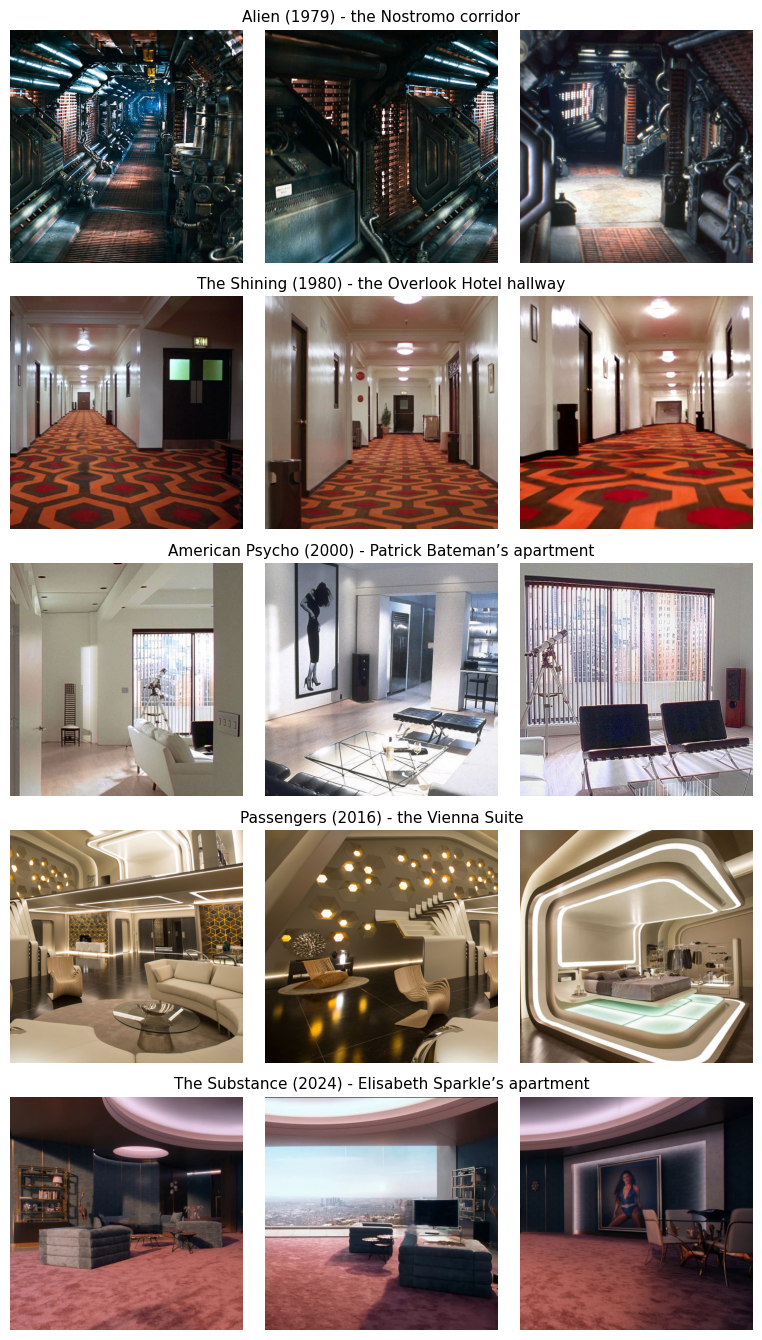

In [1]:
# ==== Visualize 3 specific training images per movie (caption = "Movie (Year)") ====
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random, re

# ---- Configure path ----
TRAIN_ROOT = Path("data")  # e.g. data/alien/*.png
MOVIES = ["alien", "shining", "as", "pas", "sub"]

# Full-title labels
MOVIE_LABELS = {
    "alien": "Alien (1979) - the Nostromo corridor",
    "shining": "The Shining (1980) - the Overlook Hotel hallway",
    "as": "American Psycho (2000) - Patrick Bateman’s apartment",
    "pas": "Passengers (2016) - the Vienna Suite",
    "sub": "The Substance (2024) - Elisabeth Sparkle’s apartment",
}

IMG_EXTS = (".png", ".jpg", ".jpeg", ".webp")
RANDOM_SEED = 0

# ---- Pick training images to visualize ----
SELECT = {
    "alien": {"files": ["train1.jpg", "train2.jpg", "train3.jpg"]},
    "shining": {
        "files": [
            "train1.jpg",
            "train2.jpg",
            "train3.jpg",
        ]
    },
    "as": {
        "files": [
            "train2.jpg",
            "train3.png",
            "train1.jpg",
        ]
    },
    "pas": {
        "files": [
            "train1.jpg",
            "train2.jpg",
            "train3.jpg",
        ]
    },
    "sub": {
        "files": [
            "train1.jpg",
            "train2.jpg",
            "train3.jpg",
        ]
    },
}


# ---- Helpers ----
def natural_key_safe(name: str):
    tokens = re.findall(r"\d+|\D+", name)
    out = []
    for t in tokens:
        if t.isdigit():
            out.append((0, int(t)))
        else:
            out.append((1, t.lower()))
    return tuple(out)


def list_images(dirpath: Path):
    paths = []
    for ext in IMG_EXTS:
        paths.extend(dirpath.glob(f"*{ext}"))
        paths.extend(dirpath.glob(f"*{ext.upper()}"))
    return sorted(paths, key=lambda p: natural_key_safe(p.name))


def pick_uniform(paths, k):
    if not paths:
        return []
    if len(paths) <= k:
        return paths[:k]
    idxs = [round(i * (len(paths) - 1) / (k - 1)) for i in range(k)]
    return [paths[i] for i in idxs]


def resolve_selected(movie_dir: Path, all_paths, spec: dict, need=3):
    chosen = []

    # 1) explicit filenames
    if spec and "files" in spec:
        for fn in spec["files"]:
            p = movie_dir / fn
            if p.exists():
                chosen.append(p)
            else:
                print(f"[warn] Missing file for {movie_dir.name}: {fn}")

    # 2) explicit indices
    if spec and "indices" in spec:
        for idx in spec["indices"]:
            if 0 <= idx < len(all_paths):
                chosen.append(all_paths[idx])
            else:
                print(
                    f"[warn] Bad index {idx} for {movie_dir.name} (n={len(all_paths)})"
                )

    # de-duplicate while preserving order
    seen = set()
    dedup = []
    for p in chosen:
        if p not in seen:
            seen.add(p)
            dedup.append(p)
    chosen = dedup

    # 3) top up to 'need' with uniform picks not already chosen
    if len(chosen) < need:
        remaining = [p for p in all_paths if p not in seen]
        fill = pick_uniform(remaining, need - len(chosen))
        chosen.extend(fill)

    # finally cap to 'need'
    return chosen[:need]


# ---- Build the grid ----
rows, cols = len(MOVIES), 3
fig_w, fig_h = cols * 2.6, rows * 2.7
fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
if rows == 1:
    axes = [axes]

for r, movie in enumerate(MOVIES):
    row_axes = axes[r] if rows > 1 else axes
    movie_dir = TRAIN_ROOT / movie
    all_paths = list_images(movie_dir)
    spec = SELECT.get(movie, {})
    img_paths = resolve_selected(movie_dir, all_paths, spec, need=3)

    # Show 3 images
    for c in range(cols):
        ax = row_axes[c]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
        if c < len(img_paths):
            im = Image.open(img_paths[c]).convert("RGB")
            ax.imshow(im)

    # Row caption
    caption = MOVIE_LABELS.get(movie, movie)
    row_axes[1].set_title(caption, fontsize=11, pad=6)

plt.tight_layout()
plt.show()